In [2]:
import rospy
from sensor_msgs.msg import PointCloud2
import sensor_msgs.point_cloud2 as pc2
from tf.transformations import rotation_matrix
import numpy as np
import cv_bridge 
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import os
import requests
import torch
import numpy as np
from PIL import Image,ImageDraw
from transformers import OwlViTProcessor, OwlViTForObjectDetection

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.3) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
perception = "/home/rilab-ur/UnseenObjectClustering"

In [4]:
CAPTURE = True

object_num = 4

if CAPTURE:
    if os.path.exists(f"{perception}/label_data.npy"):
        os.remove(f"{perception}/label_data.npy")

    if os.path.exists(f"{perception}/depth_data.npy"):
        os.remove(f"{perception}/depth_data.npy")

    if os.path.exists(f"{perception}/rgb_data.npy"):
        os.remove(f"{perception}/rgb_data.npy")

    subprocess.run([f"cd {perception}; ./experiments/scripts/ros_seg_rgbd_add_test_segmentation_realsense.sh 0 {object_num}"], shell=True)


+ set -e
+ export PYTHONUNBUFFERED=True
+ PYTHONUNBUFFERED=True
+ export CUDA_VISIBLE_DEVICES=0
+ CUDA_VISIBLE_DEVICES=0
+ outdir=data/checkpoints
+ ./ros/test_images_segmentation.py --gpu 0 --network seg_resnet34_8s_embedding --pretrained data/checkpoints/seg_resnet34_8s_embedding_cosine_rgbd_add_sampling_epoch_16.checkpoint.pth --pretrained_crop data/checkpoints/seg_resnet34_8s_embedding_cosine_rgbd_add_crop_sampling_epoch_16.checkpoint.pth --cfg experiments/cfgs/seg_resnet34_8s_embedding_cosine_rgbd_add_tabletop.yml --nums 4
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.3) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


Called with args:
Namespace(background_name=None, cfg_file='experiments/cfgs/seg_resnet34_8s_embedding_cosine_rgbd_add_tabletop.yml', dataset_name='shapenet_scene_train', gpu_id=0, instance_id=0, network_name='seg_resnet34_8s_embedding', nums=4, pretrained='data/checkpoints/seg_resnet34_8s_embedding_cosine_rgbd_add_sampling_epoch_16.checkpoint.pth', pretrained_crop='data/checkpoints/seg_resnet34_8s_embedding_cosine_rgbd_add_crop_sampling_epoch_16.checkpoint.pth', randomize=False)
Using config:
{'ANCHOR_RATIOS': [0.5, 1, 2],
 'ANCHOR_SCALES': [8, 16, 32],
 'BACKGROUND': '',
 'CAD': '',
 'DATA_PATH': '',
 'EPS': 1e-14,
 'EXP_DIR': 'tabletop_object',
 'FEATURE_STRIDE': 16,
 'FLIP_X': False,
 'FLOW_HEIGHT': 512,
 'FLOW_WIDTH': 640,
 'GPU_ID': 0,
 'INPUT': 'RGBD',
 'INTRINSICS': [],
 'MODE': 'TRAIN',
 'NETWORK': 'VGG16',
 'PIXEL_MEANS': array([[[102.9801, 115.9465, 122.7717]]]),
 'POSE': '',
 'RIG': '',
 'RNG_SEED': 3,
 'ROOT_DIR': '/home/rilab-ur/UnseenObjectClustering',
 'TEST': {'ALIGN_Z

/home/rilab-ur/.local/lib/python3.8/site-packages/torch/nn/functional.py:4070: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


0 objects


In [5]:
label_pixel = np.load(f'{perception}/label_data.npy')
depth_pixel = np.load(f'{perception}/depth_data.npy') 
rgb_pixel   = np.load(f'{perception}/rgb_data.npy')

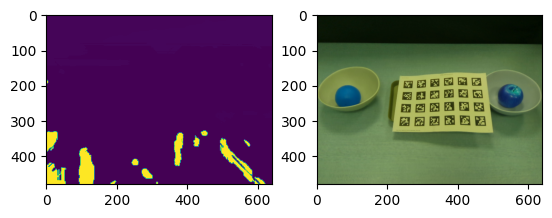

In [6]:
plt.subplot(1,2,1)
plt.imshow(depth_pixel.reshape(480, 640,-1))
plt.subplot(1,2,2)
plt.imshow(rgb_pixel/255.0)
plt.show()

#### AprilTag

In [7]:
def draw_bbox(results, image, intrinsic_matrix, verbose_bbox=False, plot_img=True):
    width = 640
    height = 480

    for r in results:
        # extract the bounding box (x, y)-coordinates for the AprilTag
        # and convert each of the (x, y)-coordinate pairs to integers
        (ptA, ptB, ptC, ptD) = r.corners
        ptB = (int(ptB[0]), int(ptB[1]))
        ptC = (int(ptC[0]), int(ptC[1]))
        ptD = (int(ptD[0]), int(ptD[1]))
        ptA = (int(ptA[0]), int(ptA[1]))

        # draw the bounding box of the AprilTag detection
        cv2.line(image, ptA, ptB, (255, 0, 0), 3)
        cv2.line(image, ptB, ptC, (255, 0, 0), 3)
        cv2.line(image, ptC, ptD, (255, 0, 0), 3)
        cv2.line(image, ptD, ptA, (255, 0, 0), 3)

        # draw the center (x, y)-coordinates of the AprilTag
        (cX, cY) = (int(r.center[0]), int(r.center[1]))
        cv2.circle(image, (cX, cY), 5, (0, 0, 255), -1)

        # draw the tag family on the image
        tagFamily = r.tag_family.decode("utf-8")
    
        if verbose_bbox:
            cv2.putText(image, tagFamily, (ptA[0], ptA[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 5.0, (255, 255, 255), 3)
            # print("Apriltag name: {}".format(tagFamily))

            x_centered = cX - width / 2
            y_centered = -1 * (cY - height / 2)

            cv2.putText(image, f"Center X coord: {x_centered}", (ptB[0] + 10, ptB[1] - 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.5, (125, 0, 125), 7)

            cv2.putText(image, f"Center Y coord: {y_centered}", (ptB[0] + 10, ptB[1]),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.0, (125, 0, 125), 7)

            cv2.putText(image, f"Tag ID: {r.tag_id}", (ptC[0] - 70, ptC[1] - 15),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (125, 0, 125), 7)

        # cv2.circle(image, (int((width / 2)), int((height / 2))), 5, (0, 0, 255), 2)

    if plot_img:
        plt.imshow(image)
        plt.show()


In [60]:
import apriltag
import cv2
import copy

label_pixel = np.load(f'{perception}/label_data.npy')
depth_pixel = np.load(f'{perception}/depth_data.npy') 
rgb_pixel   = np.load(f'{perception}/rgb_data.npy')

intrinsic_matrix = np.array([605.1119995117188, 0.0, 318.9336242675781, 0.0, 605.0845336914062, 237.35731506347656, 0.0, 0.0, 1.0])
cam_params = [intrinsic_matrix[0], intrinsic_matrix[4], intrinsic_matrix[2], intrinsic_matrix[5]]

detector = apriltag.Detector()
color_image = rgb_pixel
img_BGR = cv2.cvtColor(color_image, cv2.COLOR_RGB2BGR)
img_Gray = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2GRAY)
img_Gray = img_Gray.astype(np.uint8)

img_copy = color_image.copy()
results = detector.detect(img_Gray)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


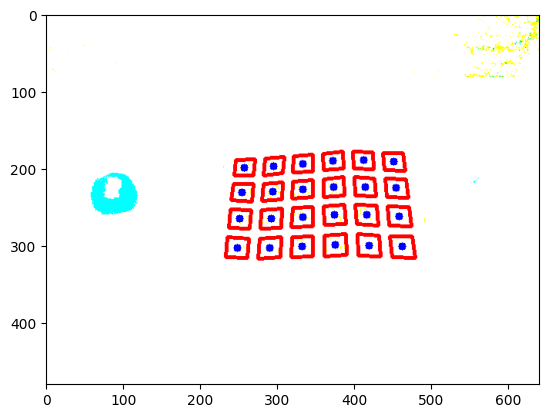

In [59]:
img_copy = copy.deepcopy(rgb_pixel)
draw_bbox(results, color_image, intrinsic_matrix=intrinsic_matrix, verbose_bbox=False, plot_img=True)


In [61]:
pose_list = []
for i in range(len(results)):
    pose, e0, e1 = detector.detection_pose(detection=results[i], camera_params=cam_params, tag_size=0.015)    # should check tag_size
    pose_list.append(pose)

print(len(pose_list))
print(pose_list[16])

24
[[ 0.93588906  0.12088879  0.33090416  0.05237671]
 [ 0.01975164  0.91979911 -0.39189216  0.0125928 ]
 [-0.35174072  0.37330348  0.85844218  0.32488666]
 [ 0.          0.          0.          1.        ]]


In [62]:
import numpy as np

local_x = np.array([0, -1, 0])
local_y = np.array([0, 0, -1])
local_z = np.array([1, 0, 0])
T = np.column_stack((local_x, local_y, local_z))

pcd_local = np.array(pose_list)[:, :3, 3]
pcd_global = np.empty_like(pcd_local)

for i in range(len(pcd_local)):
    P_local = pcd_local[i]
    P_global = np.dot(T, P_local)
    pcd_global[i] = P_global

print("Point cloud in global coordinates:\n", pcd_global)


Point cloud in global coordinates:
 [[ 0.35807669  0.03596576  0.0225864 ]
 [ 0.35080013  0.01333429  0.02327854]
 [ 0.34843713 -0.00861225  0.02494623]
 [ 0.34676075 -0.03091415  0.0265808 ]
 [ 0.34520181 -0.05312568  0.02710827]
 [ 0.34280743 -0.07512825  0.02612847]
 [ 0.347246    0.03654975  0.00354118]
 [ 0.34344268  0.01400774  0.00398724]
 [ 0.33617164 -0.0080588   0.00549819]
 [ 0.33535393 -0.03023162  0.00711443]
 [ 0.3357879  -0.05287846  0.00736483]
 [ 0.33232752 -0.07467072  0.00626016]
 [ 0.33316779  0.03689633 -0.01569612]
 [ 0.33393621  0.01458087 -0.01561311]
 [ 0.32692913 -0.00770237 -0.01403008]
 [ 0.32916792 -0.03030849 -0.0126824 ]
 [ 0.32488666 -0.05237671 -0.0125928 ]
 [ 0.3241364  -0.07483375 -0.01337575]
 [ 0.32396398  0.0377318  -0.0352145 ]
 [ 0.31598445  0.01476775 -0.03447803]
 [ 0.3193784  -0.00735414 -0.03400061]
 [ 0.31263848 -0.02928855 -0.03220823]
 [ 0.31215929 -0.05173915 -0.03233044]
 [ 0.30857961 -0.07333767 -0.03290757]]


In [42]:
import numpy as np

theta_x = 0 
theta_y = np.pi  
theta_z = np.pi  

Rx = np.array([[1, 0, 0],
               [0, np.cos(theta_x), -np.sin(theta_x)],
               [0, np.sin(theta_x), np.cos(theta_x)]])

Ry = np.array([[np.cos(theta_y), 0, np.sin(theta_y)],
               [0, 1, 0],
               [-np.sin(theta_y), 0, np.cos(theta_y)]])

Rz = np.array([[np.cos(theta_z), -np.sin(theta_z), 0],
               [np.sin(theta_z), np.cos(theta_z), 0],
               [0, 0, 1]])

pcd_tag = np.empty_like(pcd_local)

# Perform the transformation for each point in the point cloud
for i in range(len(pcd_local)):
    point_camera = pcd_local[i]
    point_tag = np.dot(R, point_camera)
    pcd_tag[i] = point_tag

print("Point cloud in tag's local coordinates:\n", pcd_tag)

Point cloud in tag's local coordinates:
 [[-0.03596576  0.0225864  -0.35807669]
 [-0.01333429  0.02327854 -0.35080013]
 [ 0.00861225  0.02494623 -0.34843713]
 [ 0.03091415  0.0265808  -0.34676075]
 [ 0.05312568  0.02710827 -0.34520181]
 [ 0.07512825  0.02612847 -0.34280743]
 [-0.03654975  0.00354118 -0.347246  ]
 [-0.01400774  0.00398724 -0.34344268]
 [ 0.0080588   0.00549819 -0.33617164]
 [ 0.03023162  0.00711443 -0.33535393]
 [ 0.05287846  0.00736483 -0.3357879 ]
 [ 0.07467072  0.00626016 -0.33232752]
 [-0.03689633 -0.01569612 -0.33316779]
 [-0.01458087 -0.01561311 -0.33393621]
 [ 0.00770237 -0.01403008 -0.32692913]
 [ 0.03030849 -0.0126824  -0.32916792]
 [ 0.05237671 -0.0125928  -0.32488666]
 [ 0.07483375 -0.01337575 -0.3241364 ]
 [-0.0377318  -0.0352145  -0.32396398]
 [-0.01476775 -0.03447803 -0.31598445]
 [ 0.00735414 -0.03400061 -0.3193784 ]
 [ 0.02928855 -0.03220823 -0.31263848]
 [ 0.05173915 -0.03233044 -0.31215929]
 [ 0.07333767 -0.03290757 -0.30857961]]


In [11]:
def compute_xyz(depth_img, camera_info):

    # , fx, fy, px, py, height, width
    fx = cam_params[0]
    cx = cam_params[2]
    fy = cam_params[1]
    cy = cam_params[3]

    height = 480
    width = 640

    indices = np.indices((height, width), dtype=np.float32).transpose(1, 2, 0)
    
    z_e = depth_img
    x_e = (indices[..., 1] - cx) * z_e / fx
    y_e = (indices[..., 0] - cy) * z_e / fy
    
    # Order of y_ e is reversed !
    xyz_img = np.stack([-y_e, x_e, z_e], axis=-1) # Shape: [H x W x 3]
    return xyz_img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


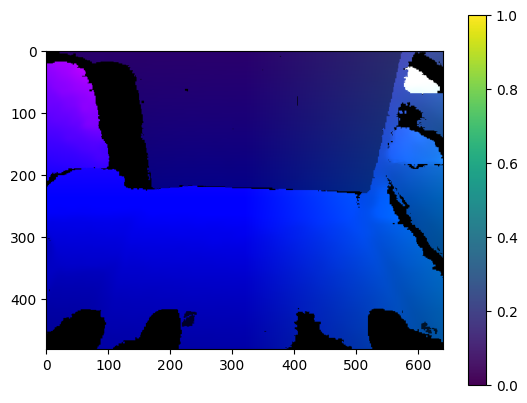

In [45]:
plt.imshow(compute_xyz(depth_pixel, cam_params))
plt.colorbar()
plt.show()

In [ ]:
label_pixel = np.load(f'{perception}/label_data.npy')
depth_pixel = np.load(f'{perception}/depth_data.npy') 
rgb_pixel   = np.load(f'{perception}/rgb_data.npy')

In [11]:
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

# image_np = np.load('./image/rgb_data.npy')
image = cv2.cvtColor(rgb_pixel, cv2.COLOR_RGB2BGR)
image = Image.fromarray(image.astype('uint8'), 'RGB')
# convert RGB to BGR

texts = [["a photo of a orange", "a photo of a apple", "a photo of a banana", "a photo of a pringles", "a photo of a choco-pie",
          "a photo of a glass", "a photo of a Fanta", "a photo of a Coke", "a photo of a Redbull"]]
inputs = processor(text=texts, images=image, return_tensors="pt")
outputs = model(**inputs)

# Target image sizes (height, width) to rescale box predictions [batch_size, 2]
target_sizes = torch.Tensor([image.size[::-1]])
# Convert outputs (bounding boxes and class logits) to COCO API
results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.1)
i = 0  # Retrieve predictions for the first image for the corresponding text queries
text = texts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]
for box, score, label in zip(boxes, scores, labels):
    box = [round(i, 2) for i in box.tolist()]
    print(f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}")

In [12]:

draw = ImageDraw.Draw(image)  # Create a drawing object for the image

i = 0  # Retrieve predictions for the first image for the corresponding text queries
text = texts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]

for box, score, label in zip(boxes, scores, labels):
    box = [round(i, 2) for i in box.tolist()]
    # Draw bounding box on the image
    draw.rectangle(box, outline="red", width=2)
    text_info = f"{text[label]} : {round(score.item(), 3)}"
    draw.text((box[0], box[1]), text_info, fill="red")

image.show()  # Display the image with bounding boxes and labels


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
